# Week 06

Regression modeling

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this week's exercises

In [2]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

from data_utils import StandardScaler
from data_utils import PolynomialFeatures
from data_utils import LinearRegression
from data_utils import regression_error
from data_utils import object_from_json_url

## Regression

Regression, or Regression Analysis, is a set of statistical processes for estimating the relationship between a dependent variable (sometimes called the 'outcome', 'response' or 'label') and one or more independent variables (called 'features', 'dimensions' or 'columns').

For example, let's say we have the following data about people's wages and years of experience:

<img src="./imgs/wages-exp.png" width="620px"/>

We could use regression to calculate how the values for wages are affected by years of experience in our dataset, and then create a function to more generally estimate the relation between wages and experience:

<img src="./imgs/wages-exp-fit.png" width="620px"/>

We could now estimate wages for values of years of experience that we didn't have measurements for.

This is an estimate, but the more points we use and the more features we have in our dataset the better the regression results will be.

### Setting up Regression

For a simple dataset we can perform regression by following these steps:

1. Load dataset
2. Encode label features as numbers
3. Normalize the data
4. Separate the outcome variable and the feature variables
5. Create a regression model
6. Run model on input data and 
7. Measure error

## Diamond Prices

Let's use the dataset from last week to set up a diamond price estimator.

Steps 1 - 3 should look familiar, and they've been pasted below:

In [4]:
## 1. Load Dataset
DIAMONDS_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/diamonds.json"

# Read into DataFrame
diamonds_data = object_from_json_url(DIAMONDS_FILE)
diamonds_df = pd.DataFrame.from_records(diamonds_data)


## 2. Encode non-numeric values
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

diamond_encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])

ccc_vals = diamond_encoder.fit_transform(diamonds_df[["cut", "color", "clarity"]].values)
diamonds_df[["cut", "color", "clarity"]] = ccc_vals


## 3. Normalize
diamond_scaler = StandardScaler()
diamonds_scaled = diamond_scaler.fit_transform(diamonds_df)

### Chose Features

Now we separate the outcome variable values and the independent variables.

Let's start simple and use only one feature: `carat`.

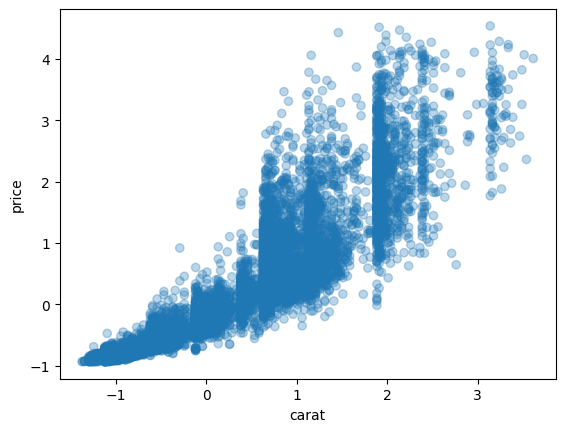

In [5]:
## 4. Separate the outcome variable and the independent variables
prices = diamonds_scaled["price"]
carats = diamonds_scaled[["carat"]]

# Plot the variables, just for checking
plt.scatter(carats, prices, marker='o', linestyle='', alpha=0.3)
plt.xlabel("carat")
plt.ylabel("price")
plt.show()

### Model

Let's setup and create a linear regression model.

We'll use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object from the `Scikit-Learn` library.

Once we create an instance of a `LinearRegression` object, we can use its `fit()` function to compute the relationship between `price` and `carat` values.

In [6]:
## 5. Create a LinearRegression object
price_model = LinearRegression()

# Create a model that relates price of diamonds to their carat value
price_model.fit(carats, prices)

### Evaluate

It's really rare for a model to perfectly capture all of the subtleties of a dataset. Models try to capture trends in the data and not all data in a dataset is gonna fit a trend.

When we run `predict()` on a dataset some/most of the predictions are gonna be off. Since we have the real values and the predicted values we can calculate how far off the predictions are.

The simplest and most obvious way to do this is to feed the features from our dataset back into our model, but this time, instead of using them to train our model, we'll compare the computed prediction values to the actual known values of the outcome variables in our dataset.

One way to formally quantify this process is to calculate the *Mean Squared Error* of our predictions, or, the average of the squares of individual errors.

It's calculated using the known values for the outcome variable $Y$, and the predicted values from our model $\hat{Y}$. For each prediction, we subtract the predicted value from the known value and square this difference. We do this for every predicted value, and sum all of these squared errors before dividing by the total number of predictions.

It can be expressed as:

$\displaystyle \frac{1}{n} \sum_{i=1}^{n}\left(Y_i - \hat{Y}_i \right)^{2}$

Luckily, the `regression_error()` function does this for us when given the $2$ lists of outcome values, $Y$ and $\hat{Y}$.

We just have to be a bit careful abut which $2$ lists we use because the results from our model are normalized, and we have normalized and un-normalized versions of our original dataset. We can compare the normalized predictions to the normalized values from the dataset, but the resulting numbers will be less intuitive and a bit harder to interpret right away.

### Un-Normalize

It might be better to perform an inverse normalization transformation on the predicted values and compare those to the original values from our dataset. If we used a `MinMaxScaler` we should now transform the predictions values, between $0$ and $1$, back to their original units. If we used `StandardScaler` we should convert the predicted values, expressed in standard deviations, back to the original units of the outcome varible.

Like all other `scikit-learn` scalers, our `diamond_scaler` object has an `inverse_transform()` function that will undo the scaling on any list of numbers we give to it.

In [7]:
## 6. Run the model on the training data
predicted_scaled = price_model.predict(carats)

# Un-normalize the data
predicted = diamond_scaler.inverse_transform(predicted_scaled)

## 7. Measure error
regression_error(diamonds_df["price"], predicted["price"])

1387.9365945007248

### Result

Hmmm.... what this means is that on average our model is wrong by $\$1388$ dollars.

We can plot our predictions with the original data:

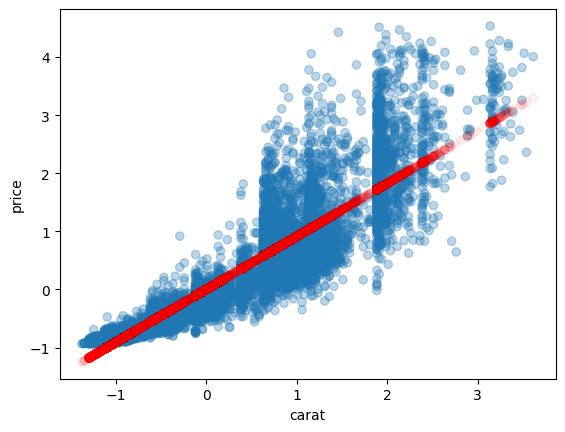

In [8]:
# Plot the original values
plt.scatter(carats, prices, marker='o', linestyle='', alpha=0.3)
plt.xlabel("carat")
plt.ylabel("price")

# Plot the predictions
plt.scatter(carats, predicted_scaled, color='r', marker='o', linestyle='', alpha=0.05)
plt.xlabel("carat")
plt.ylabel("price")
plt.show()

### Interpretation

We're only using one variable to model the price using linear regression, so, as the name suggests, the resulting model is a line:

$\displaystyle price = \beta \cdot carat$

(This should look familiar; it's the equation for a line that we might have learned in algebra: $y = m \cdot x + b$)

$\beta$ in this equation is a constant calculated by the model. The model uses all of the values about `price` and `carat` to calculate this ONE constant that defines our line.

For every value of $carat$ the model gives us a value for $price$.

### Another Graph

Another way to visualize how far off the model is from the actual data is to look at sorted lists of prices.

So, we run the model on the input, get the resulting prices, sort them and plot them against the original sorted prices.

This is just a quick way to see if there are regions of our data where the model is wrong more often, or right more often. We can combine that information with the distribution of prices in the dataset to see if it's ok for our model to be this wrong.

We could have a situation where very rare and uncommon diamond prices (too low or too high) are contributing a large amount of error to our average error. If the predictions for the more common diamond prices are close, then maybe our model is good.

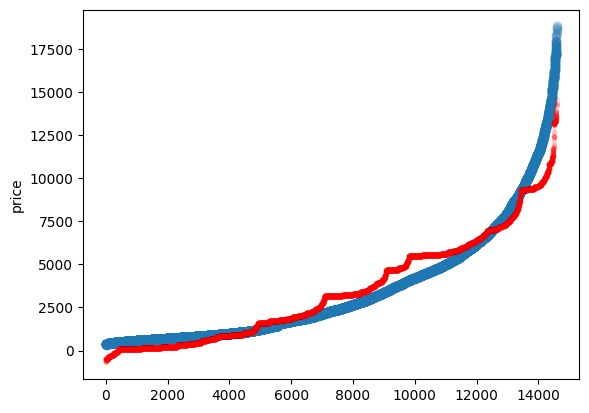

In [9]:
prices_original = diamonds_df["price"]
prices_predicted = predicted["price"]

# Plot the original and predicted prices
plt.plot(sorted(prices_original), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(prices_predicted), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("price")
plt.show()

### Interpretation

The model seems ok with lower priced diamonds, but anything more expensive than $\$6000$ seems to be more wrong.

Let's add features to the model.

### Using more features

Let's use a few more features to build our model.

This time our model equation will have multiple independent variables:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width + \beta_2 \cdot length$

The $\beta_i$ values in this equation are constants that the model calculates. There are $3$ now, so the model has more parameters to adjust in order to get a better fit.

The overall process for preparing our data is the same, but this time we'll use `carat` along with the `x` and `y` dimensions of the diamond to predict prices.

In [10]:
## 4. Separate the outcome variable and the independent variables
prices = diamonds_scaled["price"]
features = diamonds_scaled[["carat", "x", "y"]]

## 5. Create a LinearRegression object
price_model = LinearRegression()

# Create a model that relates price of diamonds to their carat value as well as width and length
price_model.fit(features, prices)

## 6. Run the model on the training data
predicted_scaled = price_model.predict(features)

# Un-normalize the data
predicted = diamond_scaler.inverse_transform(predicted_scaled)

## 7. Measure error
regression_error(diamonds_df["price"], predicted["price"])

1324.3058491942982

### Result

This is better. The error decreased.

We can plot our new model, but since we humans are limited to $3$ physical dimensions that we can comprehend, we can't plot price as a function of all $3$ of our features.

We'll create a $3D$ plot that to look at how price varies along with the length and width of the diamonds:

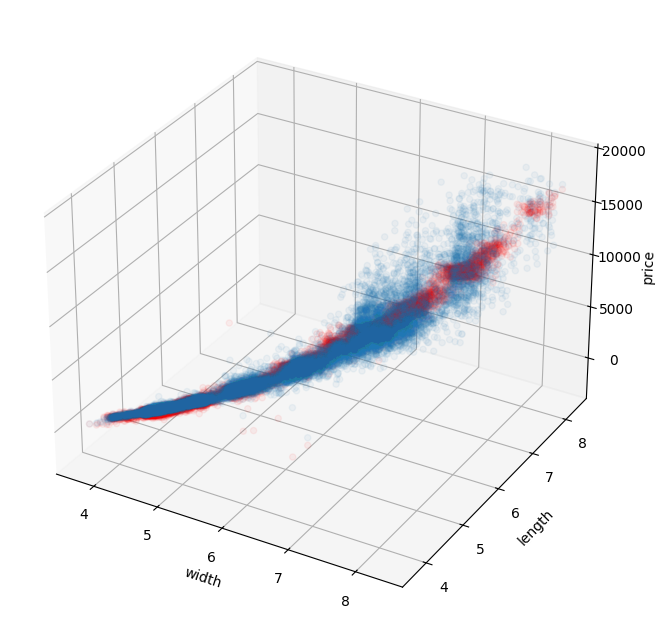

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

xs = diamonds_df[["x"]].values
ys = diamonds_df[["y"]].values

ps = diamonds_df[["price"]].values
pps = predicted[["price"]].values

ax.scatter(xs, ys, ps, marker='o', linestyle='', alpha=0.05)
ax.scatter(xs, ys, pps, color='r', marker='o', linestyle='', alpha=0.05)

ax.set_xlabel('width')
ax.set_ylabel('length')
ax.set_zlabel('price')

plt.show()

### Using ALL features

Let's use all $9$ features from the dataset to build our model.

The model equation will be something like:

$\displaystyle price = \beta_0 \cdot x_0 + \beta_1 \cdot x_1 + ... + \beta_8 \cdot x_8$

Where the $x_i$ values are the values of our features (`carat`, `width`, etc) and the $\beta_i$ parameters are the constant values that the model will calculate.

Repeat the steps below, but this time using all of the features in our dataset:

In [13]:
# TODO: repeat steps for training a predictor on all features

## 4. Separate the outcome variable and the independent variables
# Use all features *except* price
prices = diamonds_scaled["price"]
features = diamonds_scaled.drop(columns=["price"])

## 5. Create a LinearRegression object
price_model = LinearRegression()

# Create a model that relates price of diamonds to many features
price_model.fit(features, prices)

## 6. Run the model on the training data
predicted_scaled = price_model.predict(features)

# Un-normalize the data
predicted = diamond_scaler.inverse_transform(predicted_scaled)

## 7. Measure error
regression_error(diamonds_df["price"], predicted["price"])


1015.0836021399658

### Result

The error should have gotten better.

Let's sort and plot all of the prices from the original dataset and the reconstructed prices from our model.

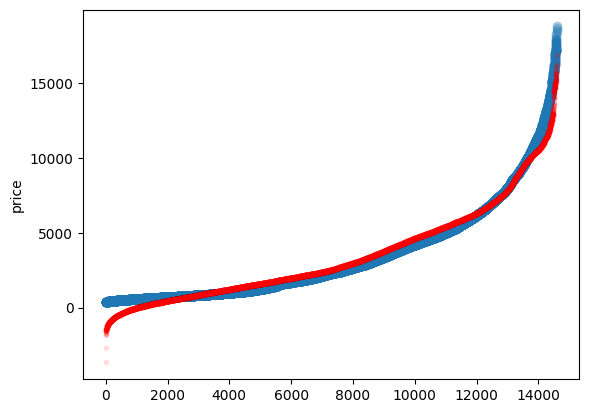

In [14]:
prices_original = diamonds_df["price"]
prices_predicted = predicted["price"]

# Plot the original and predicted prices
plt.plot(sorted(prices_original), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(prices_predicted), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("price")
plt.show()

### Interpretation

This is another one of these graphs of sorted prices that can be used to see the distribution of prices from the dataset and compare it to the prices from the model.

Depending on where on the distribution our error comes from, we can have an ok model with large errors, as long as the errors are in regions that aren't common.

In this case, there is some pretty constant error throughout the modeled prices.

The error is even worse for diamonds on the extreme ends of price: the too cheap and too expensive ones.

And since even a small percentage of error for an expensive diamond contributes to a large error in dollars, this is probably where a lot of the error is coming from.

### Even MORE Features !

One trick to improve our model is to create some extra features from the current ones.

For example, in addition to considering `carat` and `width` of each diamond separately, we can create a feature that is a combination of these two values.

Considering just those $2$ features, instead of having an equation that is like this:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width$

We can try to model an equation that has quadratic terms, like this:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width + \beta_2 \cdot carat^2 + \beta_3 \cdot width^2 + \beta_4 \cdot carat \cdot width$

Or even cubic terms:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width + \beta_2 \cdot carat^2 + \beta_3 \cdot width^2 + \beta_4 \cdot carat \cdot width + \beta_5 \cdot carat^3 + \beta_6 \cdot width^3$

This allows our model to figure out more complex relationships between the features and consider non-linear relationships between features and price (maybe `price` goes up proportional to the square of the `width` of the diamond).

Scikit-Learn has an object called [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that helps us do exactly this. We just have to instantiate it and use it to create some extra features for us.

The process of using it should loo familiar by now: instantiate an object, use its `fit_transform()` function on our features to get a new version of our data, use the new data, success.

In [ ]:
## 4. Separate the outcome variable and the independent variables
prices = diamonds_scaled["price"]
features = diamonds_scaled.drop(columns=["price"])

## 4B. Create extra features
poly = PolynomialFeatures(degree=3, include_bias=False)
features_poly = poly.fit_transform(features)

## 5. Create a LinearRegression object
price_model = LinearRegression()

# Create a model that relates price of diamonds to many features
price_model.fit(features_poly, prices)

## 6. Run the model on the training data
predicted_scaled = price_model.predict(features_poly)

# Un-normalize the data
predicted = diamond_scaler.inverse_transform(predicted_scaled)

## 7. Measure error
regression_error(diamonds_df["price"], predicted["price"])

### Result

This is significantly better than our original model.

Let's sort and plot the resulting prices again:

In [ ]:
# Plot sorted prices
prices_original = sorted(diamonds_df["price"])
prices_predicted = sorted(predicted["price"])

# Plot the original and predicted prices
plt.plot(prices_original, marker='o', linestyle='', alpha=0.3)
plt.plot(prices_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("price")
plt.show()

And this looks good, except for very cheap and very expensive diamonds.

### More plots

And since we can't see in 4D or 5D yet, let's just plot `price` as a function of a few individual features.

In [ ]:
# Plot price vs carat, x, y and z
for feat in ["carat", "x", "y", "z"]:
  x = diamonds_df[feat]
  prices_original = diamonds_df["price"]
  prices_predicted = predicted["price"]

  # Plot the original and predicted prices
  plt.plot(x, prices_original, marker='o', linestyle='', alpha=0.3)
  plt.plot(x, prices_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
  plt.xlabel(feat)
  plt.ylabel("price")
  plt.show()

# 🎉🍾

These look ok. We have a nice model for diamond prices.

## More Non-Linear Linear Regression!

This is just a quick aside into the world of _**feature engineering**_, which is the process of carefully adding data to our dataset, based on data we already have.

Let's repeat the process of linear regression for a new dataset for monthly diamond sales.

We'll follow the same steps as before:
1. Load data
2. Encode
3. Normalize
4. Choose features
5. Create model
6. Test model on input data
7. Measure error and analyze results

In [ ]:
## 1. Load Dataset
SALES_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/diamond_sales.json"

# Read into DataFrame
sales_data = object_from_json_url(SALES_FILE)
sales_df = pd.DataFrame.from_records(sales_data)

# Look at features: values, types, names, min, max, mean
for c in sales_df.columns:
  print(c, "\n\tmin:", sales_df[c].min())
  print("\tmax:", sales_df[c].max())
  print("\tavg:", round(sales_df[c].mean(), 3))
  print("\tstd:", round(sales_df[c].std(), 3))

sales_df.head()

This is a much simpler dataset with only one feature: `month`, and one outcome: `sales`.

We can easily plot all of the data just to check for any trends or specificities:

In [ ]:
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='', alpha=0.3)
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()

Looks like diamond sales to me !

Despite the spread of sale amounts between $\$1000$ and $\$6000$, we can kind of notice a slightly upward trend.

Let's check with a model.

### Model

Let's do linear regression to predict future diamond sales amounts.

In [ ]:
# TODO: train a Linear Regression predictor for sales based on month

## 3. Normalize

## 4. Separate the outcome variable and the independent variables

## 5. Create a LinearRegression object

# Use the object to create a model that relates sales amounts to month

## 6. Run the model on the training data

# Un-normalize the data

# Plot predictions
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='', alpha=0.3)
plt.plot(sales_df["month"], predicted, marker='', color='r')
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()

## 7. Measure error
regression_error(sales_df["sales"], predicted["sales"])

There's our slight upward trend... and almost $\$1000$ of average error.

### Why we look at data

Let's say that when we first plotted our data, instead of plotting dots with:

```py
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='', alpha=0.3)
```

we left out some of the parameters and plotted this instead:

```py
plt.plot(sales_df["month"], sales_df["sales"], alpha=0.3)
```

In [ ]:
plt.plot(sales_df["month"], sales_df["sales"], alpha=0.3)
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()

### Same Data, Different Story

We can now see that the ups and downs in the sales amounts aren't random, but probably correlate with the months of the year.

Whenever we want to model data like this, we have to add a special type of feature to our data in order to capture the ups and downs of cyclic, periodic values.

Just like we added new quadratic and cubic features to our linear regression equation, like this:

$\displaystyle sales = \beta_0 \cdot month + \beta_1 \cdot month^{2} + \beta_2 \cdot month^{3}$

We can add a periodic feature by using periodic functions like `sin()` and `cos()`:

$\displaystyle sales = \beta_0 \cdot month + \beta_1 \cdot \sin(month)$

We just have to define a function and then create a new column in our `DataFrame` based on this function:

In [ ]:
from math import sin, pi

# function with a period of 12 (months)
def sinx(x):
  return sin(2 * x * pi / 12.0)

# create a new column called "periodic_month" by applying sinx() to all values of month
sales_df["periodic_month"] = sales_df["month"].apply(sinx)

### Re-Model

Everything from now on is the same. We can even copy+paste the code from above:

In [ ]:
# TODO: train a Linear Regression predictor for sales based on month

# this can be exactly the same as the other cell above, as long as
# the new "periodic_month" feature is included in the data for the model

## 3. Normalize

## 4. Separate the outcome variable and the independent variables

## 5. Create a LinearRegression object

# Use the object to create a model that relates sales amounts to month

## 6. Run the model on the training data

# Un-normalize the data

# Plot predictions
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='', alpha=0.3)
plt.plot(sales_df["month"], predicted, marker='', color='r')
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()

## 7. Measure error
regression_error(sales_df["sales"], predicted["sales"])

And, just like that, our model's error got better.

## More Regression!

Let's do one more regression exercise using a different dataset.

This one is for wine quality.

In [ ]:
## 1. Load Dataset
WINE_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/wines.json"

# Read into DataFrame
wines_data = object_from_json_url(WINE_FILE)
wines_df = pd.DataFrame.from_records(wines_data)

# Look at features: values, types, names, etc
wines_df.head()

### Repeat some of the steps above to analyze the data

Specifically, steps $3$: normalize and look at the covariance matrix using `quality` as the independent variable of interest.

In [ ]:
# TODO: normalize and look at covariance matrix

## 3. Normalize

# Since this is a new dataset, let's peek at its covariance matrix

### Plot

Looks like `alcohol`, `acidity`, `density` and `chlorides` are the $4$ features that mostly contribute to the quality.

Let's look at graphs of `quality` as a function of these $4$ features.

This could be two $3D$ graphs of pairs of variables, but four $2D$ graphs is probably easier to read.

In [ ]:
# TODO: plot quality as a function of alcohol, acidity, density and chlorides

### Regression

Use the method above that we used in the diamond dataset to create a model that predicts wine `quality` as a function of **ALL** of its other features.

Use all of our features to run regression.

In [ ]:
# TODO: Create a linear model and run regression

## 4. Separate the outcome variable and the independent variables

## 5. Create a LinearRegression object

# Create a model that relates quality of wines to all other features

## 6. Run the model on the training data

# Un-normalize the data

## 7. Measure error
regression_error(wines_df["quality"], predicted["quality"])

### Plot Results

On average our predictions are within $0.77$ points of the real quality values.

Save the original `quality` values in a variable called `quality_original` and the `predicted quality` in another variable, called`quality_predicted`, and run the cell below to look at some plots of our predictions.

In [ ]:
# Plot quality vs alcohol and volatile acidity
for feat in ["alcohol", "acidity", "density", "chlorides"]:
  x = wines_df[feat]
  quality_original = wines_df["quality"]
  quality_predicted = predicted["quality"]

  # Plot the original quality
  plt.plot(x, quality_original, marker='o', linestyle='', alpha=0.3)
  plt.plot(x, quality_predicted, color='r', marker='o', linestyle='', alpha=0.3)
  plt.xlabel(feat)
  plt.ylabel("quality")
  plt.show()

### Interpretation

# 🤔

Hmm.... these could be better.

Our model wasn't able to capture the fact that the calculated `quality` value should be a discrete value and not a number with decimals.

This is because our `quality` category is not continuous, and instead can only have particular discrete values.

Instead of trying to calculate continuous values for `quality`, our model should really be trying to put the wines in the right `quality` category.

Let's use a different type of model for this task.

Instead of learning how to predict a continuous value from the independent variables, like this:

<img src="./imgs/wages-exp-fit.png" width="620px"/>

Our model should learn how to place data points into discrete groups, like this:

<img src="./imgs/wages-exp-classes.png" width="620px"/>